In [1]:
import keras
import keras.backend as K

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

import json
import pandas as pd
import numpy as np

import cv2 

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
!pip install shap

In [0]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [5]:
from keras.models import load_model

#load saved model from folder
model = load_model('/content/gdrive/My Drive/Capstone Project 2/model-1.h5', custom_objects = {'f1_m':f1_m, 'recall_m':recall_m, 'precision_m':precision_m})
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_46 (Conv2D)           (None, 198, 298, 32)      320       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 99, 149, 32)       0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 97, 147, 32)       9248      
_________________________________________________________________
max_pooling2d_38 (MaxPooling (None, 48, 73, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 46, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 23, 35, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 21, 33, 64)      

In [0]:
df_train = pd.read_csv('/content/gdrive/My Drive/Capstone Project 2/train.csv')

#convert target labels to str for keras model
df_train.label = df_train.label.astype(str)

#Shuffle dataframes
np.random.seed(7)
df_train = df_train.sample(frac=1)

In [7]:
df_train.head()

,file_path,condition,label
325,/content/gdrive/My Drive/Capstone Project 2/ch...,pneumonia,1
680,/content/gdrive/My Drive/Capstone Project 2/ch...,pneumonia,1
4033,/content/gdrive/My Drive/Capstone Project 2/ch...,normal,0
2451,/content/gdrive/My Drive/Capstone Project 2/ch...,pneumonia,1
145,/content/gdrive/My Drive/Capstone Project 2/ch...,pneumonia,1


In [0]:
img1 = cv2.imread(df_train.loc[325,'file_path'], cv2.IMREAD_GRAYSCALE)
img1 = cv2.resize(img1, (300,200))

img2 = cv2.imread(df_train.loc[680,'file_path'], cv2.IMREAD_GRAYSCALE)
img2 = cv2.resize(img1, (300,200))

img3 = cv2.imread(df_train.loc[4033,'file_path'], cv2.IMREAD_GRAYSCALE)
img3 = cv2.resize(img1, (300,200))

In [0]:
images = [cv2.imread(x,cv2.IMREAD_GRAYSCALE) for x in df_train.file_path.head(3)]
images = [cv2.resize(x, (300,200)) for x in images]
images = np.asarray(images).reshape(3,200,300,1)

In [0]:
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout
from keras import regularizers, optimizers
from keras import Sequential

import shap

In [11]:
!pip install keract

#Keract

Reference

https://github.com/philipperemy/keract

Using Keract, we can see the activations of each filter in a convolution layer.

conv2d_47 (1, 97, 147, 32) 


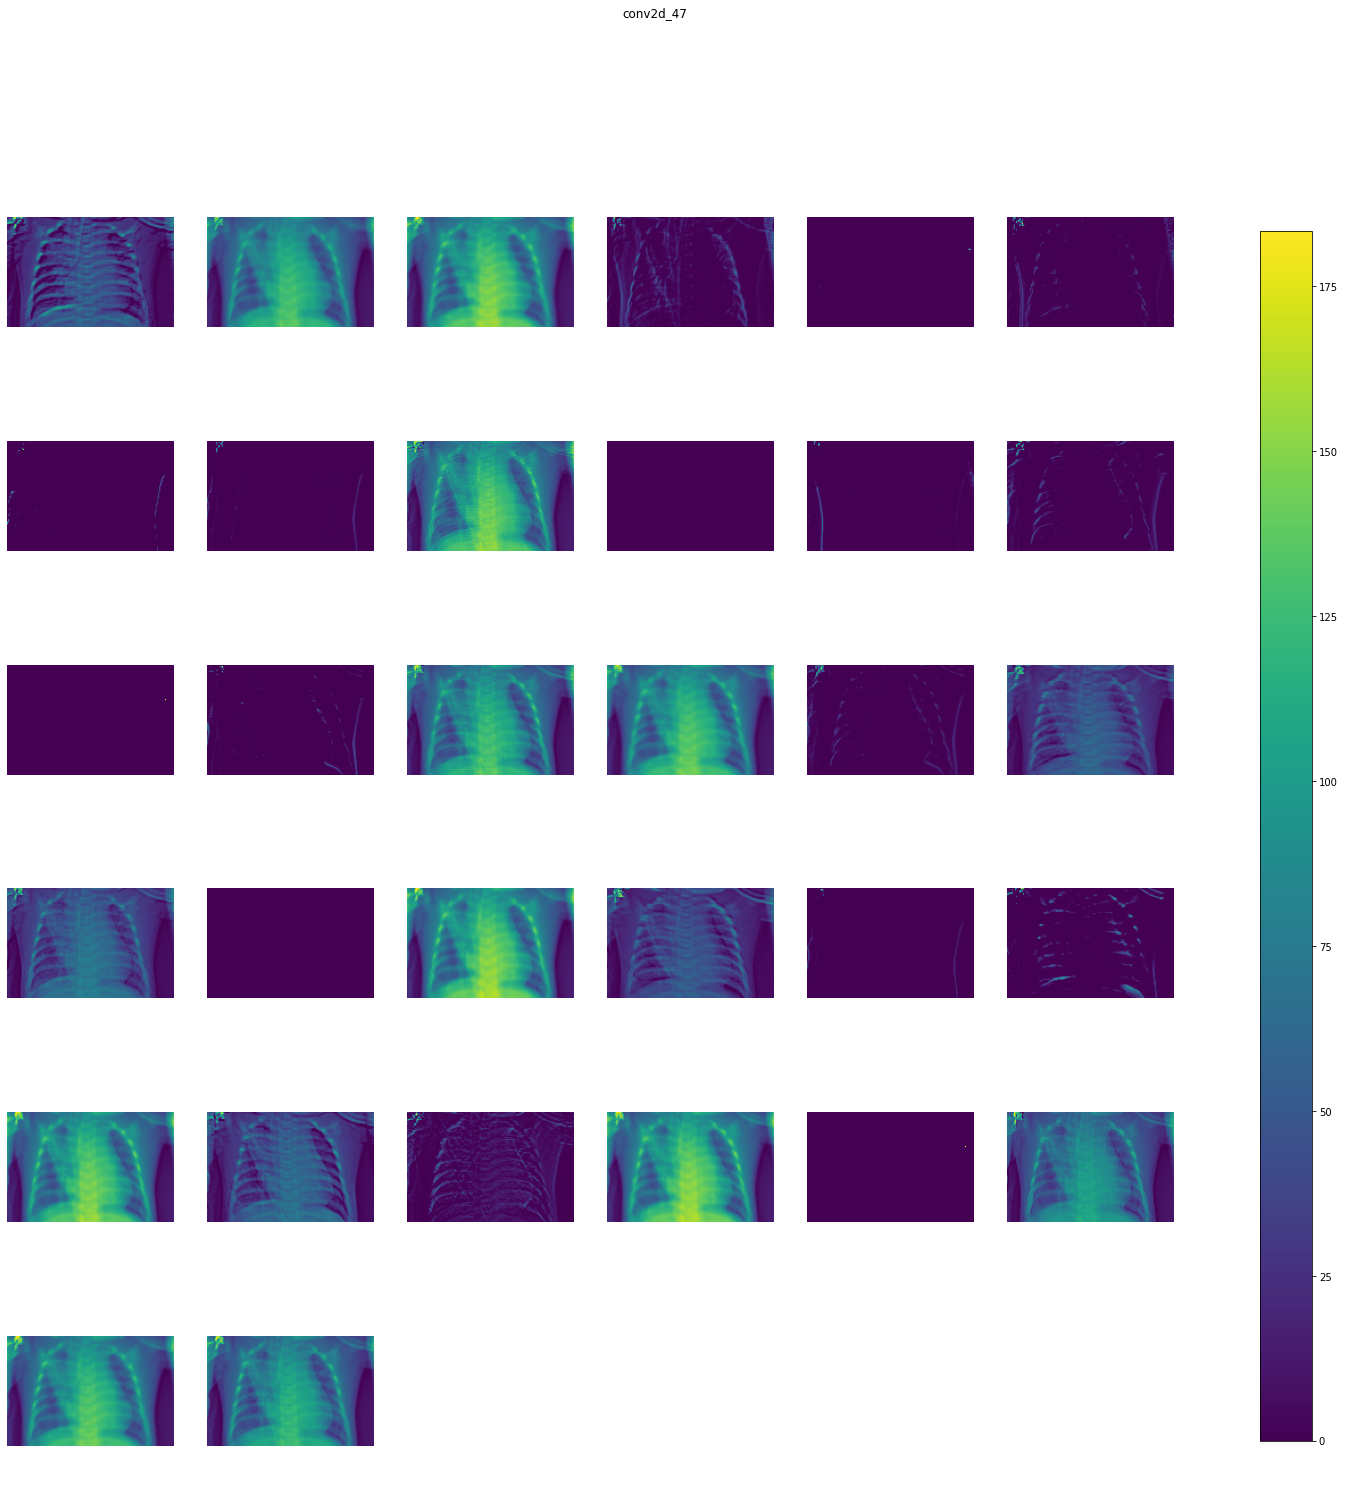

In [12]:
from keract import get_activations, display_activations
from keract import display_heatmaps

activations = get_activations(model, images[0].reshape(1,200,300,1), layer_name = 'conv2d_47')
display_activations(activations, save=False)

conv2d_49 (1, 21, 33, 64) 


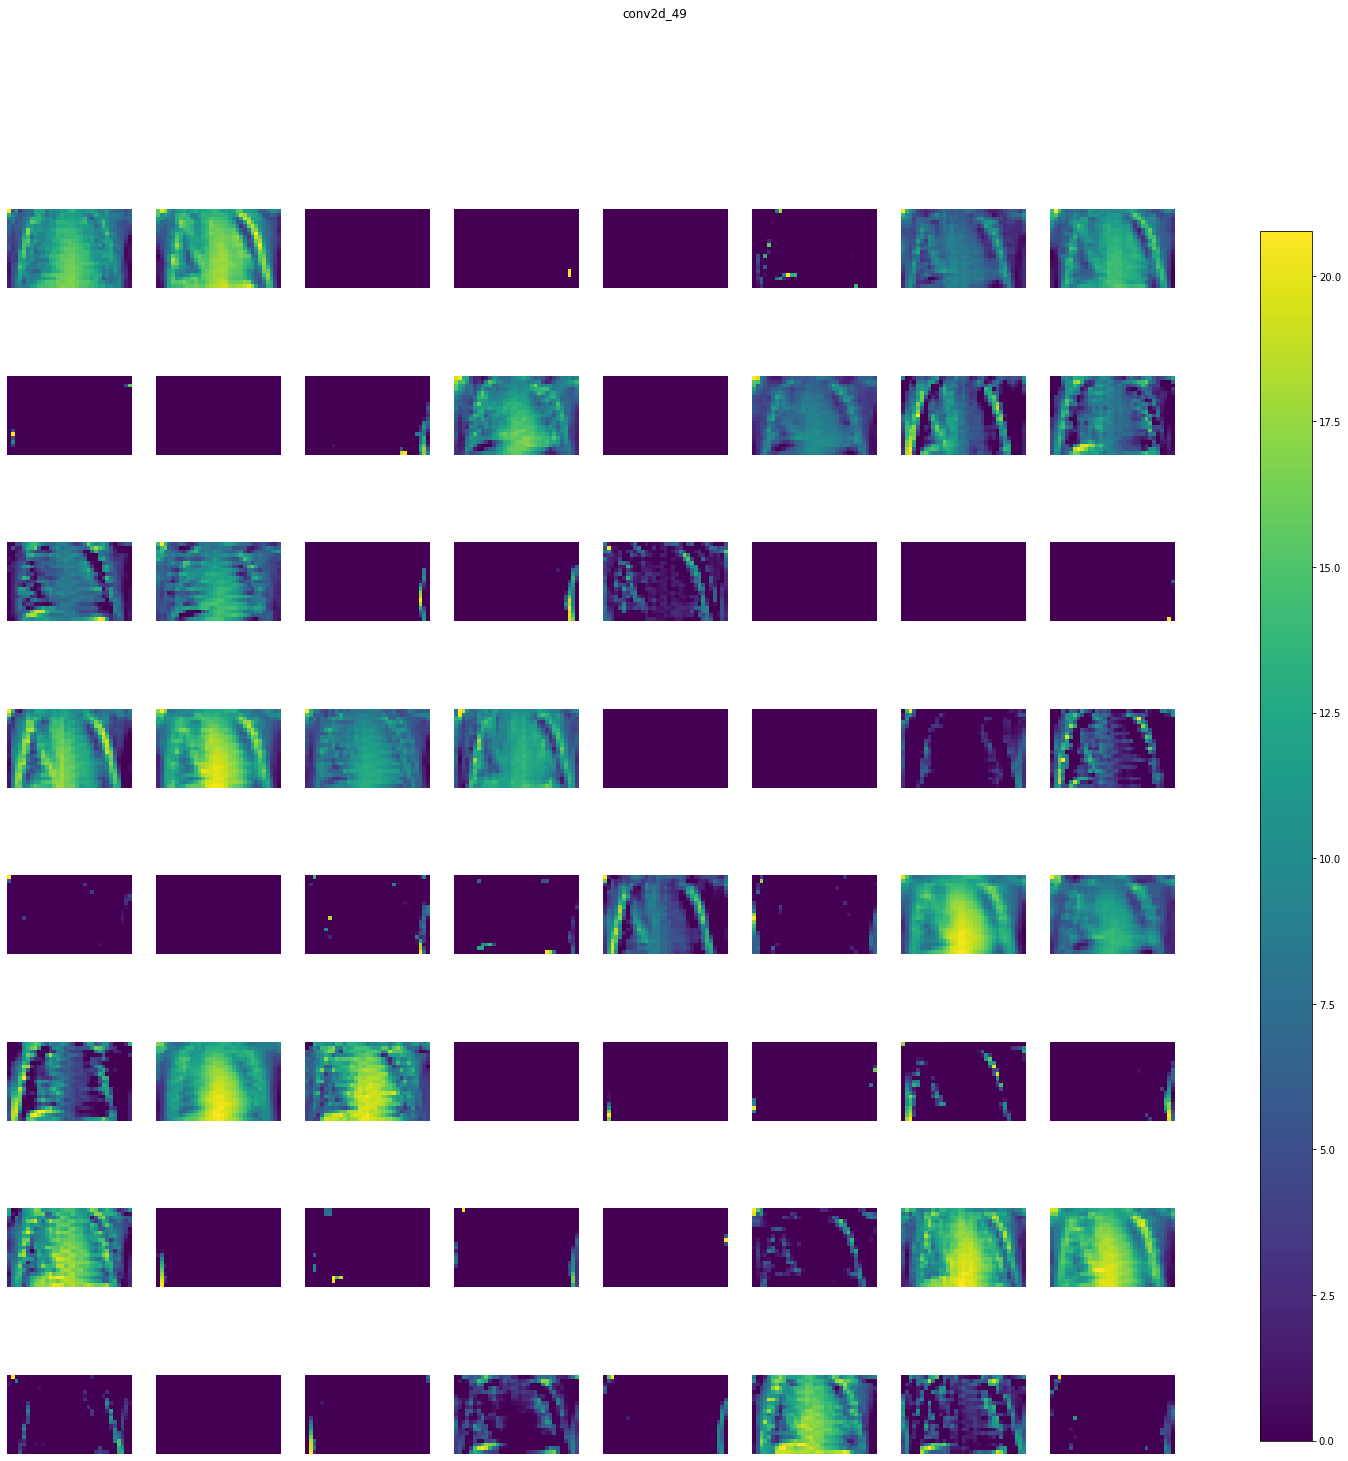

In [15]:
activations = get_activations(model, images[0].reshape(1,200,300,1), layer_name = 'conv2d_49')
display_activations(activations, save=False)

conv2d_50 (1, 8, 14, 128) 


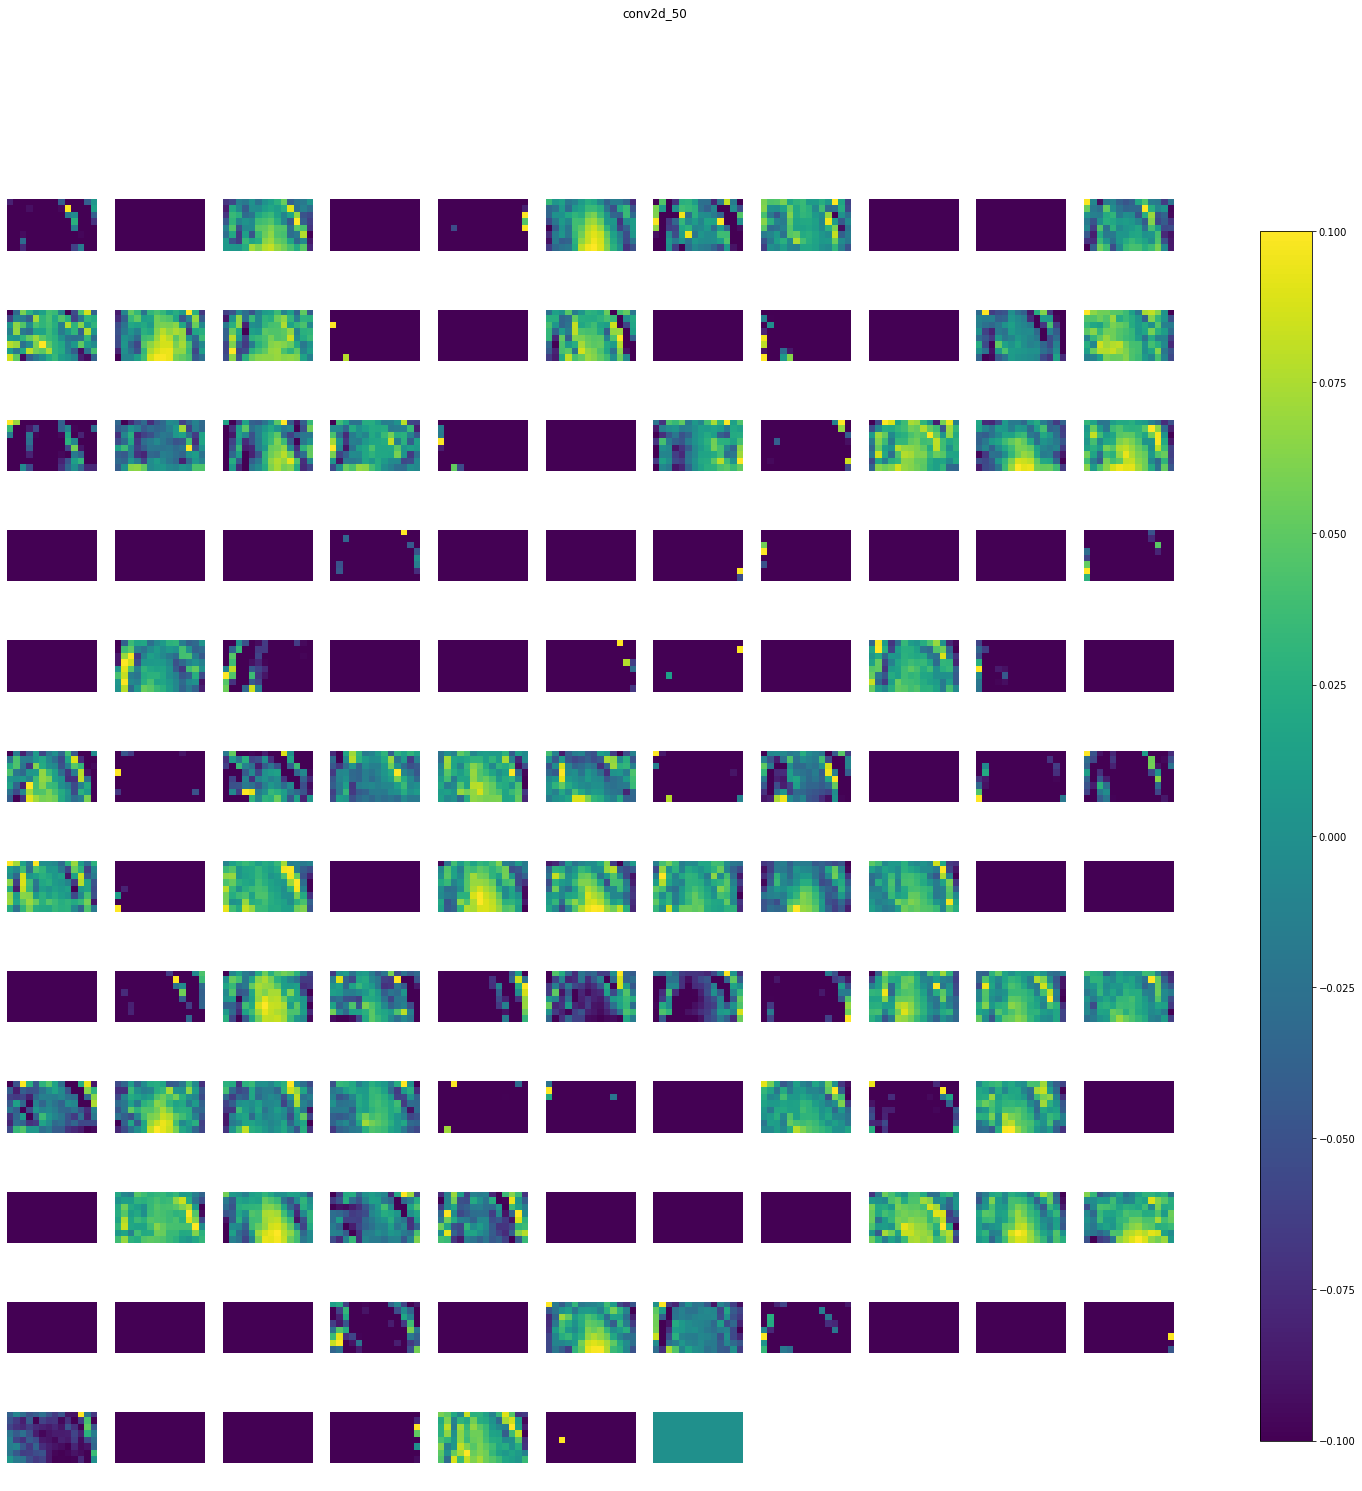

In [16]:
activations = get_activations(model, images[0].reshape(1,200,300,1), layer_name = 'conv2d_50')
display_activations(activations, save=False)

#Grad-CAM

Reference:

https://towardsdatascience.com/demystifying-convolutional-neural-networks-using-gradcam-554a85dd4e48

https://colab.research.google.com/drive/1AG4MbfaMQGARlGMzjanWnlqcroxhRTVw


Using the techniques explored above, we can generate heatmaps using the gradients of a convolution layer to get a better sense of what the model is seeing.

In [0]:
def make_heatmap(x, layer):
  #get layer from our model
  last_conv = model.get_layer(layer)
  #get gradients
  gradients = K.gradients(model.output, last_conv.output)[0]
  mean_gradients = K.mean(gradients, axis=(0,1,2))

  extractor_fn = K.function([model.input], [mean_gradients, last_conv.output[0]])
  mean_grad_vals, conv_output = extractor_fn([x.reshape(1,200,300,1)])        

  conv_output[:, :, 0] *= mean_grad_vals[0]

  #generate heatmaps
  heatmap = np.mean(conv_output, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  #resize heatmap to same size as original image
  upsized_cam_image = cv2.resize(heatmap, (300,200))

  return upsized_cam_image

Let's take a closer look at 10 randomly selected images from our dataset

In [0]:
#generate list of random index from our dataset
np.random.seed(9)
random_list = np.random.randint(0,len(df_train), 10)

In [0]:
#generate images and heatmaps for our 10 image indexes
heat_map_list = []
image_list = []
for index in random_list:
  temp_image = cv2.imread(df_train.loc[index,'file_path'],cv2.IMREAD_GRAYSCALE)
  temp_image = cv2.resize(temp_image, (300,200))
  temp_heatmap = make_heatmap(temp_image, 'conv2d_50')
  image_list.append(temp_image)
  heat_map_list.append(temp_heatmap)

In [0]:
#get the true labels from our dataset
condition_list = df_train.loc[random_list,'condition'].reset_index(drop=True)

In [0]:
#generate predictions using our model on the randomly selected images
prediction = model.predict(np.array(image_list).reshape(10,200,300,1))

Let's plot the heat maps for our 10 randomly selected images 

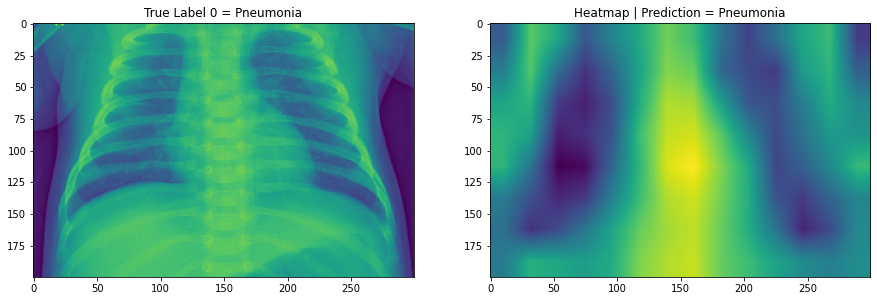

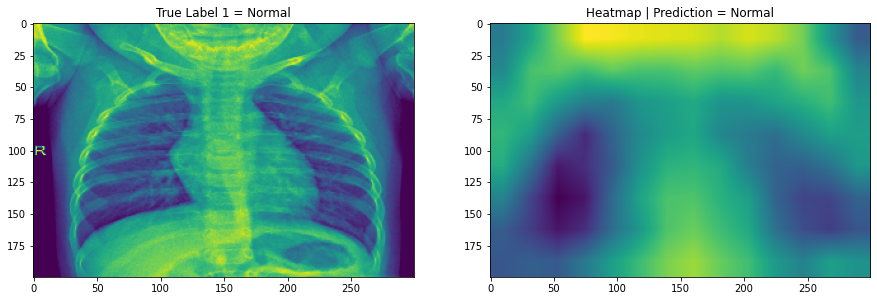

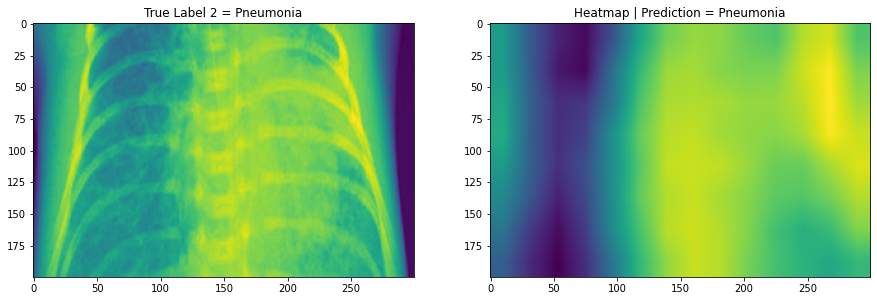

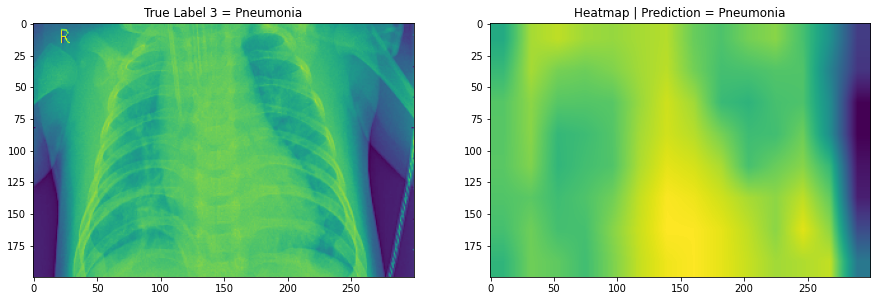

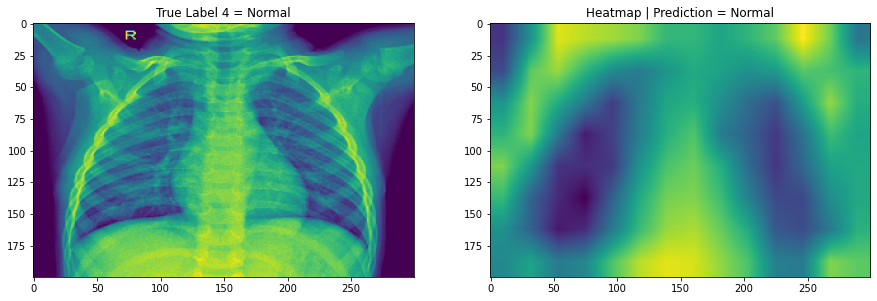

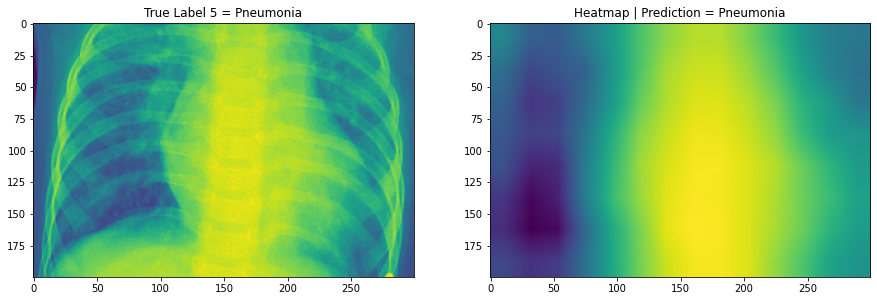

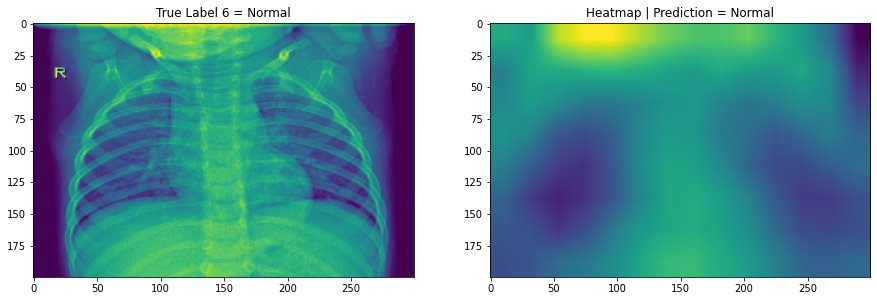

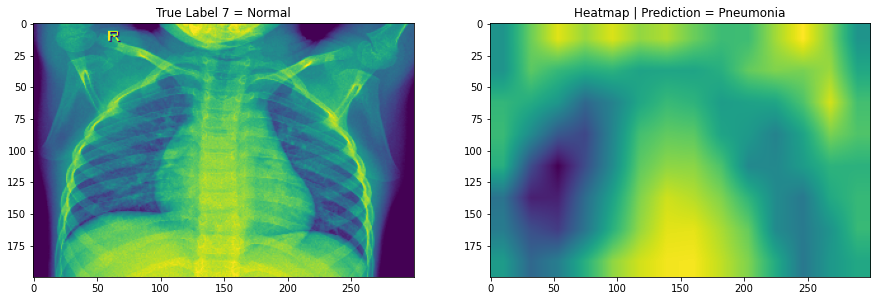

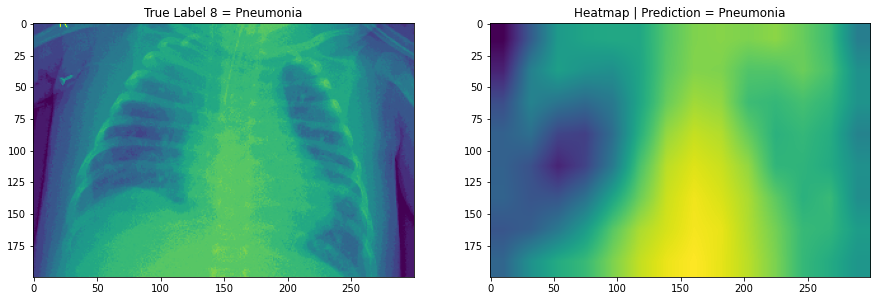

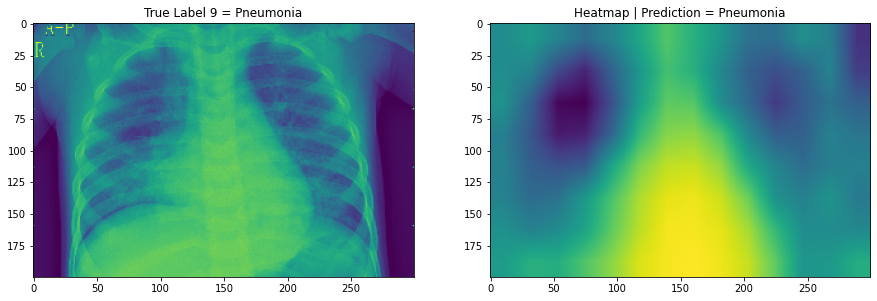

In [23]:
for i in range(0,len(heat_map_list)):  
  plt.figure(figsize=(15,7))
  plt.axis('off')
  plt.subplot(1,2,1)
  plt.imshow(image_list[i].reshape(200,300))
  title = 'True Label ' + str(i) + ' = ' + condition_list[i].capitalize()
  plt.title(title)
  plt.subplot(1,2,2)
  plt.imshow(heat_map_list[i].reshape(200,300))
  title = 'Heatmap | Prediction = ' + ('Pneumonia' if prediction[i] > 0.5 else 'Normal')
  plt.title(title)
  plt.show()

#Conclusion

Looking at our heatmaps, we can gain a better understanding of what our model is focusing on when it looks at the x-ray images to make predictions.  It appears that the model predicts the existance of pneumonia when there is an area of high intensity towards the center of the image (the lungs).  Example number 7 wrongly predicted as having pneumonia, and taking a closer look we can see that at the center of the heatmap for example 7 there is an area of high intensity at the center of the image.  Contrast this with example 6, and maybe we can gain a better understanding of what the model is doing to classify these x-ray images.